In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf   
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img
from tensorflow.keras.applications import ResNet50,Xception
from tensorflow.keras.models import Sequential,Model   
from tensorflow.keras.layers import Dense,Input, GlobalAveragePooling2D, Dense, Dropout, multiply, Reshape, Conv2D, Activation, Add, Dropout, GlobalAveragePooling2D, BatchNormalization, Multiply,MaxPooling2D,Concatenate,Conv2D, UpSampling2D, Cropping2D,Lambda
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler,ModelCheckpoint

import shutil
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import Accuracy

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import matplotlib.pyplot as plt    
import matplotlib.image as mpimg

In [4]:
# Set the image size and batch size for training
batch_size =16

In [5]:
# Define input shape 
input_shape = (400,400,3)
    

In [6]:
train_dataset_dir='/kaggle/input/isic-2017-preprocessed-augmented/content/Linear_Exact_Aug/Train'   

In [17]:
Valid_dataset_dir='/kaggle/input/isic-2017-preprocessed-augmented/content/Linear_Exact_Aug/Valid'   

In [8]:
# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  
)

In [9]:
# Load the training dataset with data augmentation
train_generator = train_datagen.flow_from_directory(
    train_dataset_dir,   
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
)

Found 14018 images belonging to 3 classes.


In [13]:
test_dataset_dir = '/kaggle/input/isic-2017-preprocessed-augmented/content/Linear_Exact_Aug/Test' 

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_data_generator = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to the range [0, 1]
    # Add any other preprocessing options if needed
)

test_generator = test_data_generator.flow_from_directory(
    test_dataset_dir,    
    target_size=(400,400),  # Adjust to match your model's input size
    batch_size=16,           # Adjust batch size as needed   
    class_mode='categorical',  # If you have class labels
    shuffle=False              # Do not shuffle test data
)

Found 600 images belonging to 3 classes.


In [18]:
# Data normalization for validation and testing
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)   

In [19]:
# Load the validation dataset
val_generator = val_datagen.flow_from_directory(
    Valid_dataset_dir,   
    target_size=input_shape[:2],
    batch_size=batch_size,    
    class_mode='categorical'
)

Found 150 images belonging to 3 classes.


In [20]:
# Create an input layer
input_layer = Input(shape=input_shape)   

In [21]:
import tensorflow_hub as hub    

In [22]:
bit_l_url = "https://tfhub.dev/google/bit/m-r101x1/1"   

In [23]:
# Load the BiT L model from TensorFlow Hub
bit_l_model = hub.KerasLayer(bit_l_url, trainable=True)
bit_l_output = bit_l_model(input_layer)    

In [24]:
bit_l_output_reshaped = Reshape((1, 1, -1))(bit_l_output)  # Reshape to match the expected shape

In [25]:
# Load the Xception model without top classification layers
xception_base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in xception_base_model.layers:
    layer.trainable = True     

83683744/83683744 [==============================] - 0s 0us/step


In [26]:
# Connect the input layer to the base models
xception_features = xception_base_model(input_layer)


In [27]:
combined_features =multiply([xception_features,bit_l_output_reshaped])   

In [28]:
# Apply Squeeze-and-Excitation block
def se_block(input_tensor):   
    num_channels = input_tensor.shape[-1]
    
    # Squeeze operation (Global Average Pooling)
    squeeze = GlobalAveragePooling2D()(input_tensor)
    squeeze = Reshape((1, 1, num_channels))(squeeze)
    
    # Excitation operation (Fully connected layers)
    excitation = Dense(num_channels // 16, activation='relu')(squeeze)
    excitation = Dense(num_channels, activation='sigmoid')(excitation)
    
    # Scale the input feature maps
    scaled_features = multiply([input_tensor, excitation])
    
    return scaled_features

In [29]:
se_output = se_block(combined_features)
   

In [30]:
# Add a classification head to the combined features
from tensorflow.keras.regularizers import l2
x = tf.keras.layers.GlobalAveragePooling2D()(se_output)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.1)(x)
x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='selu',kernel_regularizer=l2(0.02))(x)
x = BatchNormalization()(x)
output = tf.keras.layers.Dense(3, activation='softmax')(x)  # 7output classes


In [31]:
# Create the ensemble model
model = Model(inputs=input_layer, outputs=output)    

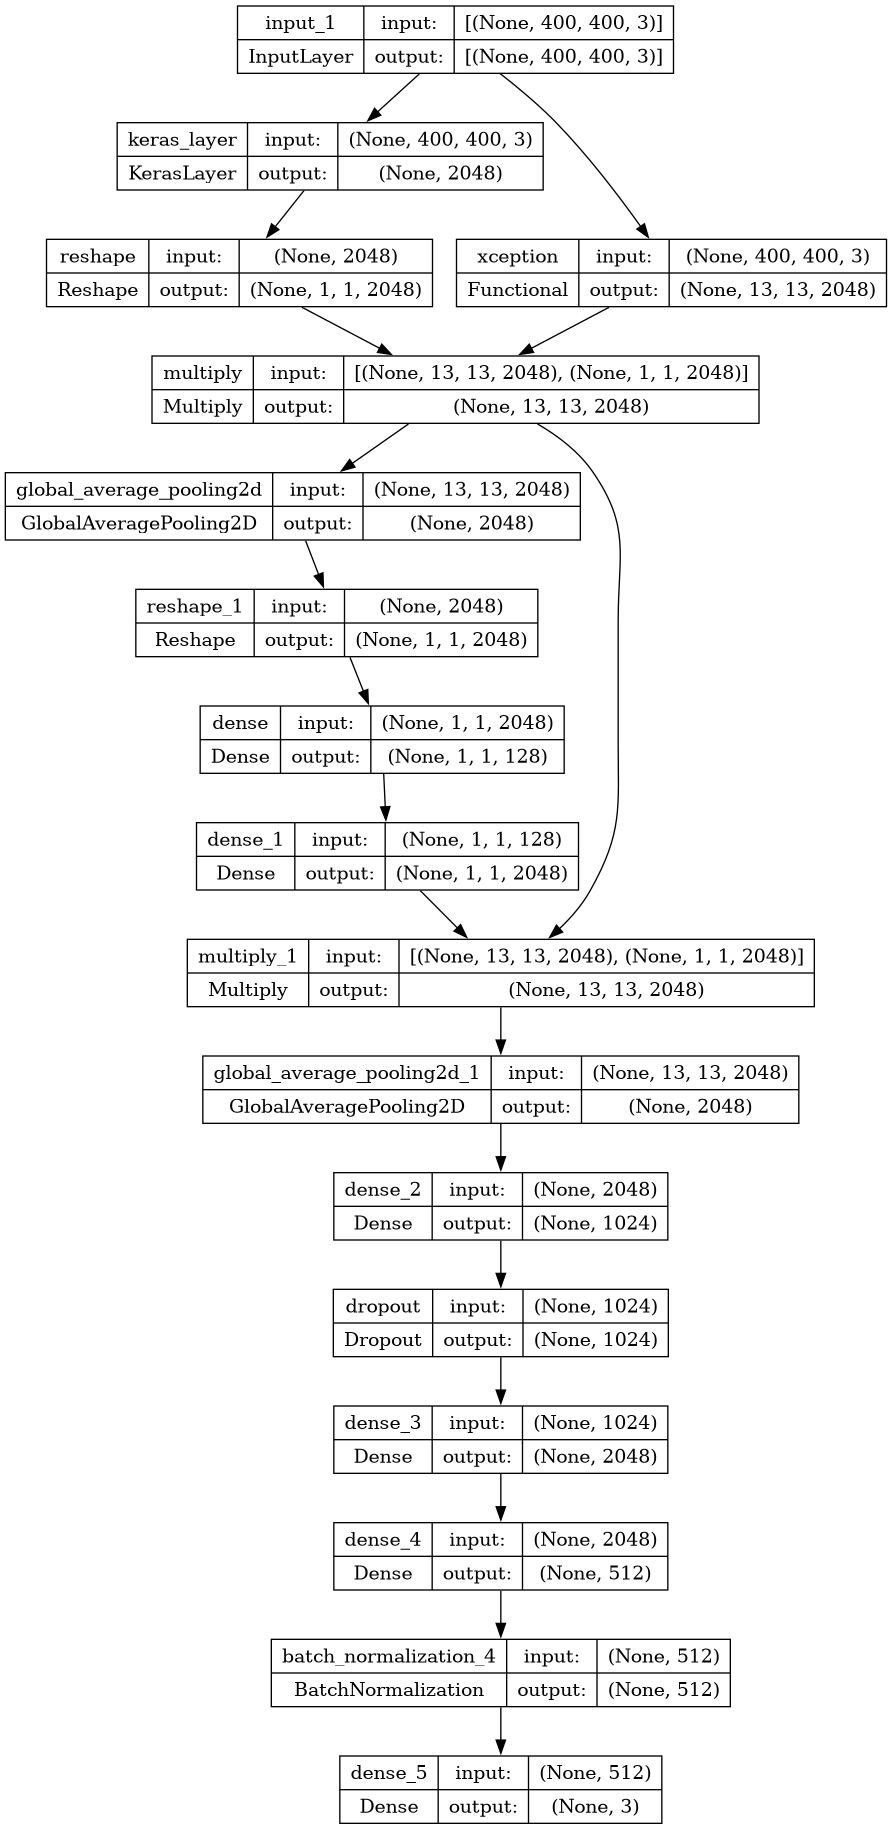

In [32]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Define your model here
model = model

# Specify the file path where you want to save the model architecture image
image_path = 'model_architecture.png'

# Plot the model architecture and save it as an image
plot_model(model, to_file=image_path, show_shapes=True, show_layer_names=True)

In [33]:
model.summary()   

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 keras_layer (KerasLayer)    (None, 2048)                 4249248   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 xception (Functional)       (None, 13, 13, 2048)         2086148   ['input_1[0][0]']             
                                                          0                                       
                                                                                              

In [34]:
import tensorflow as tf
from tensorflow.keras.losses import categorical_crossentropy

def combined_loss(y_true, y_pred, alpha=0.2, categorical_weight=0.5):
    # Compute the categorical cross-entropy loss
    cat_loss = categorical_crossentropy(y_true, y_pred)

    # Reshape the inputs to get anchor, positive, and negative examples
    anchor = tf.reshape(y_pred[:, 0], shape=(-1, 1))
    positive = tf.reshape(y_pred[:, 1], shape=(-1, 1))
    negative = tf.reshape(y_pred[:, 2], shape=(-1, 1))

    # Compute the distance between the anchor and the positive
    pos_distance = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    
    # Compute the distance between the anchor and the negative
    neg_distance = tf.reduce_sum(tf.square(anchor - negative), axis=1)

    # Compute the triplet loss
    triplet_basic_loss = pos_distance - neg_distance + alpha
    triplet_loss = tf.reduce_mean(tf.maximum(triplet_basic_loss, 0.0), axis=0)

    # Compute the combined loss
    combined_loss = categorical_weight * cat_loss + (1 - categorical_weight) * triplet_loss

    return combined_loss

# Example usage in a Keras model
model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy'])


In [35]:
# Implement learning rate scheduling   
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)

In [36]:

# Define the model checkpoint callback to save the best weights
model_checkpoint = ModelCheckpoint('ISIC2017_Classification_contour_ensemble5.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True, verbose=1)

In [37]:
# Implement early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, verbose=1, restore_best_weights=True)

In [31]:
# Train the model
epochs =30
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=epochs,   
    validation_data=val_generator,
    validation_steps=val_generator.samples // 32,
    callbacks=[lr_scheduler,model_checkpoint,early_stopping]
)

Epoch 1/30
438/438 [==============================] - ETA: 0s - loss: 3.4768 - accuracy: 0.5771
Epoch 1: val_accuracy improved from -inf to 0.40625, saving model to ISIC2017_Classification_contour_ensemble5.h5
438/438 [==============================] - 694s 1s/step - loss: 3.4768 - accuracy: 0.5771 - val_loss: 1.8640 - val_accuracy: 0.4062 - lr: 0.0010
Epoch 2/30
438/438 [==============================] - ETA: 0s - loss: 0.4825 - accuracy: 0.6574
Epoch 2: val_accuracy did not improve from 0.40625
438/438 [==============================] - 561s 1s/step - loss: 0.4825 - accuracy: 0.6574 - val_loss: 1.3583 - val_accuracy: 0.2812 - lr: 0.0010
Epoch 3/30
438/438 [==============================] - ETA: 0s - loss: 0.3907 - accuracy: 0.7032
Epoch 3: val_accuracy did not improve from 0.40625
438/438 [==============================] - 562s 1s/step - loss: 0.3907 - accuracy: 0.7032 - val_loss: 3.0373 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/30
438/438 [==============================] - ETA

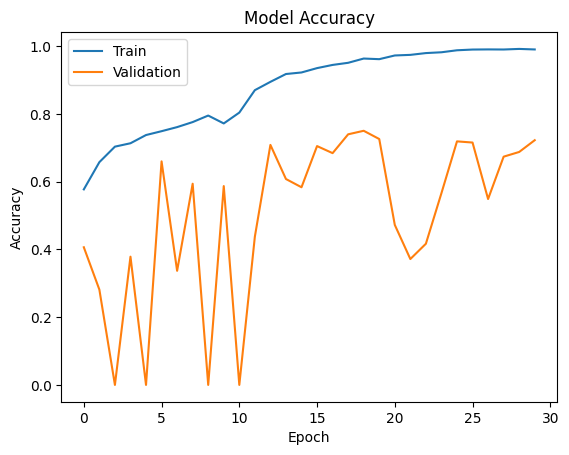

In [32]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

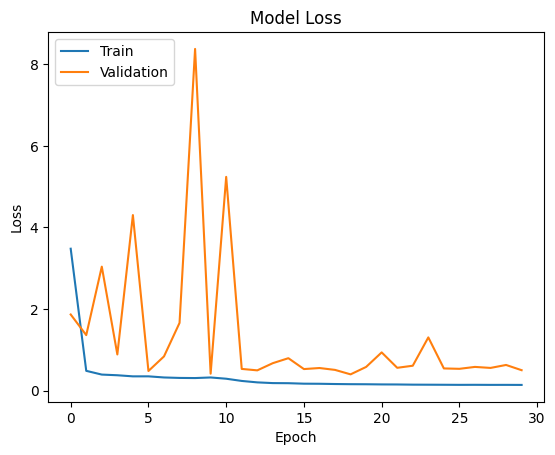

In [33]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')   
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [29]:
from tensorflow.keras.models import load_model

#Load the saved weights from the output directory in the executed model architecture .  
model.load_weights('/kaggle/working/ISIC2017_Classification_contour_ensemble5.h5')



In [40]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")    
print(f"Test Accuracy: {test_accuracy}")
    

75/75 [==============================] - 70s 927ms/step - loss: 0.4652 - accuracy: 0.7950
Test Loss: 0.4651944041252136
Test Accuracy: 0.7950000166893005


75/75 [==============================] - 71s 936ms/step


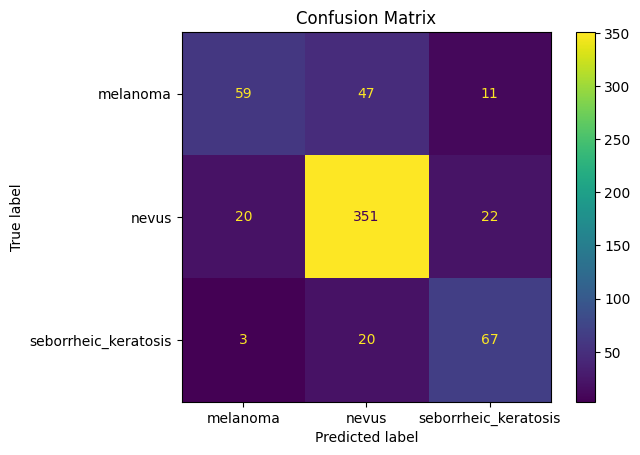

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#  the true labels and predicted labels for the test dataset
y_true = test_generator.classes
y_pred = model.predict(test_generator).argmax(axis=1)
   
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
    
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

In [42]:
labels = {0:'melanoma', 1:'nevus', 2:'seborrheic_keratosis'}
    

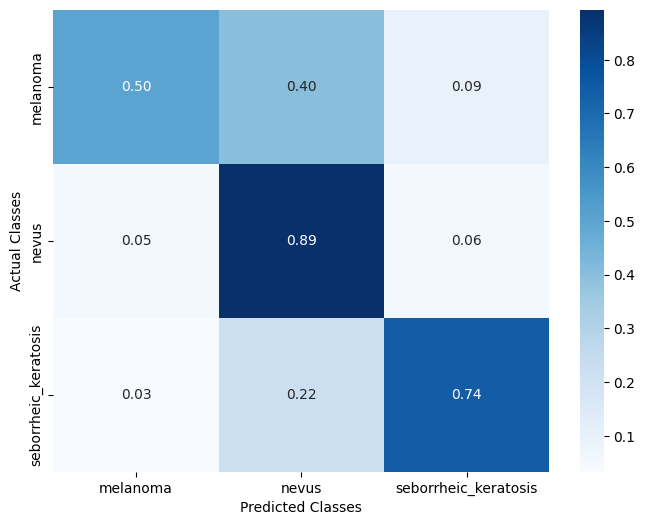

Confusion Matrix:
[[ 59  47  11]
 [ 20 351  22]
 [  3  20  67]]
              precision    recall  f1-score   support

           0       0.72      0.50      0.59       117
           1       0.84      0.89      0.87       393
           2       0.67      0.74      0.71        90

    accuracy                           0.80       600
   macro avg       0.74      0.71      0.72       600
weighted avg       0.79      0.80      0.79       600



In [43]:
import seaborn as sns
from sklearn.metrics import classification_report
cm = confusion_matrix(y_true, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]   
fig, ax = plt.subplots(figsize=(8,6))  
sns.heatmap(cmn, annot=True, xticklabels=labels.values(), yticklabels=labels.values(),cmap=plt.cm.Blues, fmt='.2f')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show(block=False)    
   
# Generate the classification report
report = classification_report(y_true, y_pred)

print("Confusion Matrix:")
print(cm)    
print(report)     

In [47]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score: " + str(f1))
     

Precision: 0.7908168397712686
Recall: 0.795
Accuracy: 0.795
F1 Score: 0.7883843221559156


In [48]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score: " + str(f1))
    

Precision: 0.7430750379274128
Recall: 0.7139492399034384
Accuracy: 0.795
F1 Score: 0.7212753363807812


In [49]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
f1 = f1_score(y_true, y_pred, average='micro')
print("F1 Score: " + str(f1))
         

Precision: 0.795
Recall: 0.795
Accuracy: 0.795
F1 Score: 0.795


75/75 [==============================] - 76s 1s/step


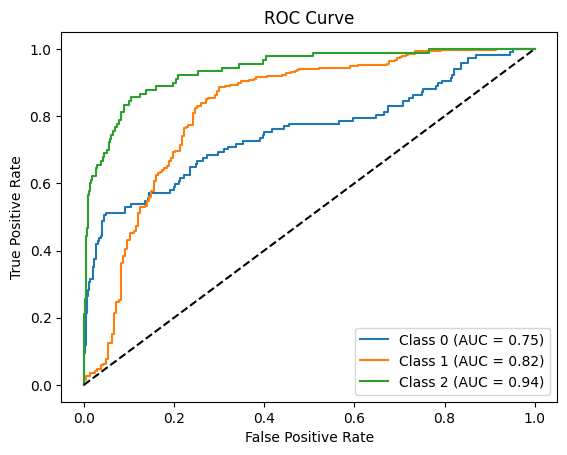

In [50]:
from sklearn.metrics import roc_curve, auc
y_true = test_generator.classes   
# Get the probabilities for each class (0 and 1) from the model predictions
y_prob = model.predict(test_generator)

# Compute the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(train_generator.num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
   
# Plot the ROC curves
plt.figure()
for i in range(train_generator.num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [54]:
from sklearn.metrics import roc_auc_score    
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))
print("macro Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='macro')))    
print("micro Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='micro')))  

weighted Roc score: 0.8267742729942218
macro Roc score: 0.8381728673912218
micro Roc score: 0.8790083333333334
